# uTensor: Deep Learning Inference Engine Born for Embedded System


by [`Dboy Liao`](https://github.com/dboyliao)

[slido](https://app.sli.do/event/imdxbmlc/live/questions)

# About Me

- A Python Developer
- Interested in machine learning, applied math and its development
- Core developer of [`uTensor`](https://utensor.github.io/website/)

## Our Team

![utensor-team](images/utensor-team.jpg)

## Where the Journey Started, Exoskeleton

![outer-skeleton](images/outer-skeleton.png)

## What We Want

- A smart sensor other than hand-crafted one

- Adaptive, customizable

- Runs on low-powered devices

- User friendly and easy to debug

By the time being, Deep Neural Network technology seems to be our best bet. (Maybe?)

## Tensorflow Lite Micro

![tensorflow-logo](images/tensorflow-logo.svg)

- [documentation](https://www.tensorflow.org/lite/microcontrollers)
- Interpretor based
    - model is represented as an array of bytecodes ([example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/model.cc#L28-L237))
    - `tflite::MicroInterpreter` carry out the output values with the bytecodes ([tutorial](https://www.tensorflow.org/lite/microcontrollers/get_started))
    - Tensorflow Lite Micro only

## `uTensor`

![utensor](images/uTensorFlow.jpg)

## `utensor_cgen`: Code Generator for `uTensor`

![utensor-cgen](images/utensor-cli-components.drawio.svg)

- Example: `Quantization`

![weight-quantization](images/weight-quantization.png)
[credit](https://docs.google.com/presentation/d/1zGm5bqGrkAepwJZ5PABiYjrIKq1pDnzafa8ZYeaFhXY/edit)

## Agenda

Before we move on to how to extend `utensor-cli`, we need to understand how `uTensor` runtime works.

We'll go through following tutorials

1. Hello World
2. Error Handling
3. Operator Interface
4. Model Interface
5. End-to-End Deployment

And finally, write a simple plugin/extension for `utensor-cli`

# Tutorial 1: Hello World!


[hello_world.cpp](https://github.com/dboyliao/PyDataTP_2020/blob/master/1_hello_world/hello_world.cpp)

![hello-world](images/hello-world.png)

## Heterogeneous Tensor Storage


```cpp
// tensor with data allocated on ROM
Tensor rom_tensor = new RomTensor({10, 3}, u8, ptr_to_data);

// tensor with data allocated on SRAM
Tensor ram_tensor = new RamTensor({10, 3}, flt);
```

## Unified Tensor Read/Write Interface


```cpp
class Tensor : public Handle {
  ....
  const IntegralValue operator()(uint32_t linear_index) const;
  IntegralValue operator()(uint32_t linear_index);
  ....
}
```

- `IntegralValue` is like raw bytes which can be interpreted/casted to various values
- Before `IntegralValue`:
    - `tensor->read<float>(idx)`
    - Pros: better syntax (maybe) 
    - Cons: binary size grows as template specializatons

```cpp
// Reading from Tensor
float value = static_cast<float>(tensor(2));

// Writing to Tensor
float value = 3.0;
tensor(2) = value;
```

- Supported types of `IntegralValue`

```cpp
enum ttype : uint8_t { i8, u8, i16, u16, i32, u32, flt, undefined };
```

## Memory Allocator


```cpp
static localCircularArenaAllocator<512> meta_alloc;
static localCircularArenaAllocator<sizeof(float)*12> ram_alloc;

int main(int argc, const char **argv) {
  Context::get_default_context()->set_metadata_allocator(&meta_alloc);
  Context::get_default_context()->set_ram_data_allocator(&ram_alloc);
  ...
}
```

- As allocator created, it will hold a memory pool as the size asigned
    - Depends on when and how allocators being created, the memory pool can be allocated at compile time or runtime.
- ram allocator controls memory allocation of `RamTensor`
- meta allocator controls memory allocation of metadata of `Tensor`, such as shape, element type, ...etc
- semi-strong guarantee on memory usage

In [1]:
from utensor_cgen.logger import logger
from utensor_cgen.frontend.tflite import TFLiteParser
from utensor_cgen.backend.graph_lower.generic_graph_lower import TensorAllocationPlanner

logger.setLevel("ERROR")

parser = TFLiteParser({})
planner = TensorAllocationPlanner({})
ugraph = parser.parse('./5_end2end_deployment/simple_cnn.tflite')

In [2]:
logger.setLevel("INFO")
planner.apply(ugraph)

[INFO generic_graph_lower.py apply @ 56] topo ordered tensor life span analysis done
[INFO utils.py wrapped @ 469] collapsed time of calling apply: 0.0044 seconds
[INFO generic_graph_lower.py _solve_space_alloc @ 204] optimal tensor allocation plan solved, total memory required: 172544 bytes
[INFO generic_graph_lower.py _solve_space_alloc @ 205] number of tensors allocated: 24
[INFO utils.py wrapped @ 469] collapsed time of calling _solve_space_alloc: 0.0147 seconds


In [3]:
for v in ugraph.attributes[planner.KWARGS_NAMESCOPE].plan.values():
    print(v.entity.name, '->', [v.offset_start, v.offset_end])

sequential_1/conv2d_4/Conv2D__StatefulPartitionedCall/sequential_1/conv2d_4/Conv2D:0 -> [0, 1727]
unknown_4:0 -> [0, 511]
sequential_1/conv2d_7/Relu__StatefulPartitionedCall/sequential_1/conv2d_7/Relu__sequential_1/conv2d_7/BiasAdd__StatefulPartitionedCall/sequential_1/conv2d_7/BiasAdd__sequential_1/conv2d_7/Conv2D__StatefulPartitionedCall/sequential_1/conv2d_7/Conv2D__unknown_6:0 -> [0, 1023]
unknown_6:0 -> [1024, 2047]
conv2d_4_input_int8:0 -> [1728, 4799]
Identity_int8:0 -> [0, 9]
2_CONV_2D/ReLU:0 -> [0, 32767]
sequential_1/conv2d_6/Conv2D__StatefulPartitionedCall/sequential_1/conv2d_6/Conv2D:0 -> [512, 147967]
sequential_1/conv2d_7/Conv2D__StatefulPartitionedCall/sequential_1/conv2d_7/Conv2D:0 -> [2048, 34815]
sequential_1/flatten_1/Reshape__StatefulPartitionedCall/sequential_1/flatten_1/Reshape:0 -> [10, 265]
5_CONV_2D/ReLU:0 -> [1024, 2047]
1_CONV_2D/ReLU:0 -> [0, 65535]
sequential_1/max_pooling2d_2/MaxPool__StatefulPartitionedCall/sequential_1/max_pooling2d_2/MaxPool:0 -> [14796

In [ ]:
from utensor_cgen.ir.misc.graph_viz import viz_memalloc
figs = viz_memalloc(ugraph, num_tensors_per_split=10)

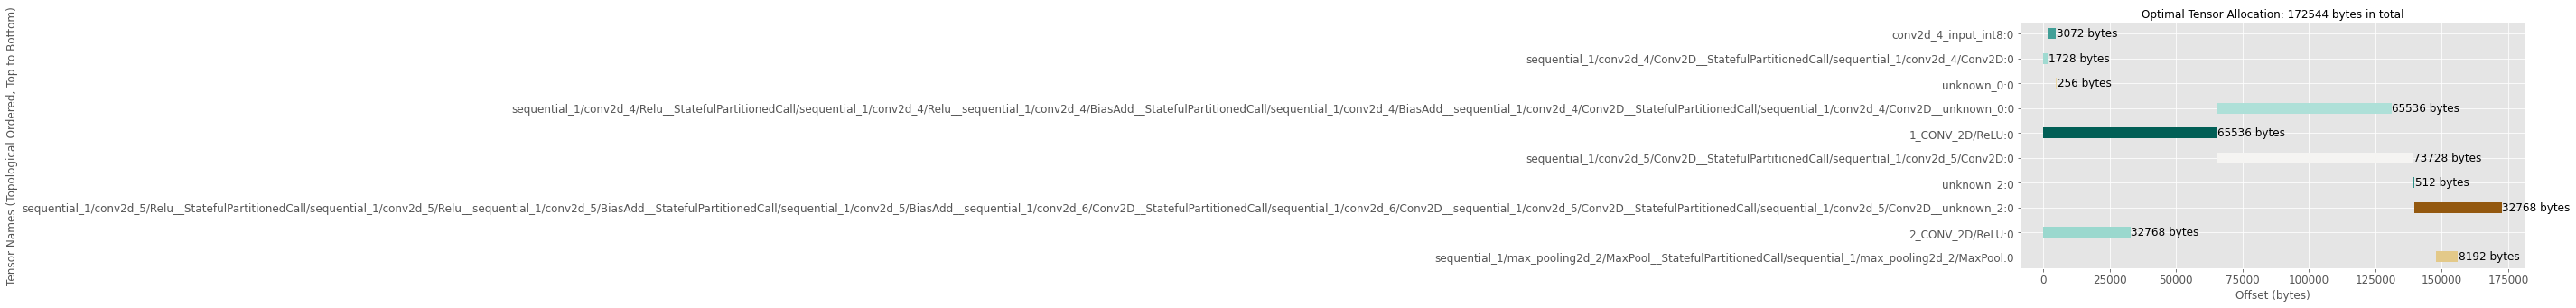

In [9]:
figs[0]

![mlp_alloc](images/mlp_alloc.png)

# Tutorial 2: Error Handling and Debugging

[error_handling.cpp](https://github.com/dboyliao/PyDataTP_2020/blob/master/2_error_handling/error_handling.cpp)

![error-handling](images/error-handling.png)

## Simple Error Handler: A Spinning Handler

```cpp
// create an error handler
static SimpleErrorHandler error_handler(3);

int main(int argc, const char **argv) {
  Context::get_default_context()->set_metadata_allocator(&meta_alloc);
  Context::get_default_context()->set_ram_data_allocator(&ram_alloc);
  // setup error handler
  Context::get_default_context()->set_ErrorHandler(&error_handler);
  ...
}
```

![error-handling-lldb](images/error-handling-lldb.png)

![error-handling-lldb-2](images/error-handling-lldb-2.png)

# Tutorial 3: Operator Interface

[operator_interface.cpp](https://github.com/dboyliao/PyDataTP_2020/blob/master/3_operator_interface/operator_interface.cpp)

![operator-interface](images/operator-interface.png)

## `OperatorInteface`

```cpp
template <size_t num_inputs, size_t num_outputs>
class OperatorInterface : public OperatorBase {
 ...

 protected:
  virtual void compute() = 0;
};
```

To implement an operator, you must

1. inherent from `OperatorInterface` and specify the number of inputs/outputs
2. overwrite `void compute()`

- Let's write an operator which print ASCII characters by its code

```cpp
// It's a operator with 1 input and 0 output
class ASCIIPrintOperator : public OperatorInterface<1, 0> {
 public:
  enum names_in : uint8_t { msg }; // the input names
  ...

 protected:
  // compute() will be invoked once the operator is evaluated
  void compute() {
    // retrieve tensor by its name
    Tensor &msg_tensor = inputs[msg].tensor();
    ...
  }
  ...
};
```

```cpp
ASCIIPrintOperator op;
...

op
  // set inputs by names
  .set_inputs({{ASCIIPrintOperator::msg, msg}})
  // evaluate the op
  .eval();
```

```cpp
ReferenceOperators::AddOperator<uint8_t> add_op;
...
    
add_op
  .set_inputs({
      {ReferenceOperators::AddOperator<uint8_t>::a, msg},
      {ReferenceOperators::AddOperator<uint8_t>::b, ones},
  })
  .set_outputs({{ReferenceOperators::AddOperator<uint8_t>::c, outputs}})
  .eval();
```

[Caesar Cipher](https://en.wikipedia.org/wiki/Caesar_cipher)

# Tutorial 4: Model Interface

[model_interface.cpp](https://github.com/dboyliao/PyDataTP_2020/blob/master/4_model_interface/model_interface.cpp)

![model-interface](images/model-interface.png)

```cpp
template <size_t num_inputs, size_t num_outputs>
class ModelInterface : public ModelBase {
 ...

 protected:
  virtual void compute() = 0;
};
```

- `ModelInterface` is designed to mimic `OperatorInterface`
- To implement a model, you must:
  1. inherent from `ModelInterface` with specific inputs/outputs numbers
  2. overwrite `void compute()` virtual method

```cpp
// a model with 1 input tensor and 1 output tensor
class MyModel : public ModelInterface<1, 1> {
 public:
  // names of input/output tensors
  enum names_in : uint8_t { msg };
  enum names_out : uint8_t { output };

 private:
  ...
  // private memory allocator, which controls total memory consumption of a model
  localCircularArenaAllocator<256> meta_alloc;
  localCircularArenaAllocator<256> ram_alloc;

 protected:
  void compute() {
    // carry out the operator evaluation over here
    ...
  }
};
```

```cpp
// allocator for tensors outside of the model
static localCircularArenaAllocator<128> meta_alloc;
static localCircularArenaAllocator<128> ram_alloc;

int main(int argc, const char **argv) {
  Context::get_default_context()->set_metadata_allocator(&meta_alloc);
  Context::get_default_context()->set_ram_data_allocator(&ram_alloc);
  Tensor msg = new RomTensor({12}, u8, msg_codes);
  Tensor output = new RamTensor({12}, u8);
  // create model
  MyModel mymodel(true);
  // set input/output tensors and evaluate
  mymodel.set_inputs({{MyModel::msg, msg}})
      .set_outputs({{MyModel::output, output}})
      .eval();
  return 0;
}
```

# Tutorial 5: End-to-End Deployment

[5_end2end_deployment](https://github.com/dboyliao/PyDataTP_2020/tree/master/5_end2end_deployment)

![end2end](images/end2end.png)

In [1]:
from utensor_cgen.api.export import tflm_keras_export
import tensorflow as tf
import numpy as np

In [2]:
model = tf.keras.models.load_model('./5_end2end_deployment/simple_cnn.h5')

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
y_train = y_train.astype('float32')
x_test = x_test.astype('float32') / 255.0
y_test = y_test.astype('float32')

In [4]:
def representative_dataset():
    for idx in np.random.randint(0, x_train.shape[0], 1024):
        yield [x_train[[idx]]]

In [ ]:
tflm_keras_export(
    model,
    representative_dataset,
    model_name="simple_cnn",
    output_tflite_fname="simple_cnn.tflite"
)

![tflite-export](images/tflite-export.png)

### Demo

![nucleo-f767zi](images/nucleo-f767zi.jpg)

![demo-stack-overflow](images/demo-stack-overflow.png)

After adding `static` to all quantization parameters

![end2end](images/end2end.png)

# `utensor_cgen` Plugin

[component_registration](https://github.com/uTensor/utensor_cgen/tree/master/tutorials/component_registration)

![utensor-cli-components](images/utensor-cli-components.drawio.svg)

- A `plugin` for `utensor_cgen` is just a python module, which can be a `.py` file or a directory

- Each component in `utensor_cgen` is open for registration. That is, you can extend `utenssor-cli` however you like

- Let's see an example how to extend `utensor-cli` to generate different target files

## `Backend`

```python
from utensor_cgen.backend import BackendManager
from utensor_cgen.backend.base import Backend
from utensor_cgen.utils import class_property


@BackendManager.register
class DummyBackend(Backend):
    TARGET = 'dummy-backend'

    def __init__(self, config):
        self.output_file = self.config[self.TARGET][self.COMPONENT]['output-file']

    def apply(self, ugraph):
        # you will be given an optimized, target-specific graph
        # and then you can do whatever you like with it such as generating files,
        # printing details, ...etc
        import pdb
        pdb.set_trace()
        with open(self.output_file, 'w'):
            # do stuff
            ...

    @class_property
    def default_config(cls):
        return {
            cls.TARGET: {
                    cls.COMPONENT: {
                    'output-file': 'list_op.c'
                }
            }
        }
```

```python
class DummyBackend(Backend):
    TARGET = <target name>
    ...
```

- Each `Backend` must provide a `TARGET` as its target name (a string)

- Will be applied by `utensor-cli -p <myplugin> convert --target=<target name> <model_file>`

```python
def __init__(self, config):
    self.output_file = self.config[self.TARGET][self.COMPONENT]['output-file']

@class_property
def default_config(cls):
    return {
        cls.TARGET: {
                cls.COMPONENT: {
                <key>: <value>,
                ...
            }
        }
    }
```

- `default_config` should return a dictionary with the spec as above example

- a dictionary with the same spec of the value returned by `default_config` will be passed to `__init__`
- the backend object should be initialized accordingly

## Demo

```bash
$ utensor-cli \
  -p submodules/utensor_cgen/tutorials/component_registration/my_plugins \
  convert --target 'dummy-backend' \
  5_end2end_deployment/simple_cnn.tflite
$ clang -O3 list_op.c -o list_op
```

![demo-plugin](images/demo-plugin.png)